In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Functions

In [2]:
def Weigfun( Tlag): 
    # WEIGFUN Summary of this function goes here
    #   Detailed explanation goes here
    nmax=int(np.ceil(Tlag))
    if nmax==1: 
        Weigths=float(1)
    else:
        Weigths=np.zeros(nmax)

        th=Tlag/2
        nh=int(np.floor(th))
        for i in range(0,nh): 
            Weigths[i]=(float(i+1)-0.5)/th	    
        i=nh

        Weigths[i]=(1+(float(i+1)-1)/th)*(th-int(np.floor(th)))/2+(1+(Tlag-float(i+1))/th)*(int(np.floor(th))+1-th)/2
        for i in range(nh+1, int(np.floor(Tlag))):
            Weigths[i]=(Tlag-float(i+1)+.5)/th

        if Tlag>int(np.floor(Tlag)):
            Weigths[int(np.floor(Tlag))]=(Tlag-int(np.floor(Tlag)))**2/(2*th)

        Weigths=Weigths/sum(Weigths)

    return(Weigths)

### HBV

In [3]:
def HBVMod( Par,forcing,Sin, hydrograph,spin_up_time='FALSE'):
    #HBVpareto Calculates values of 3 objective functions for HBV model

    Imax=Par[0]
    Ce=Par[1]
    Sumax=Par[2]
    beta=Par[3]
    Pmax=Par[4]
    Tlag=Par[5]
    Kf=Par[6]
    Ks=Par[7]


    Prec=forcing[:,1]
    Q0=forcing[:,0]
    Etp=forcing[:,2]


    tmax=len(Prec)
    Si=np.zeros(tmax)
    Su=np.zeros(tmax)
    Sf=np.zeros(tmax)
    Ss=np.zeros(tmax) 
    Eidt=np.zeros(tmax)
    Eadt=np.zeros(tmax)
    Qtotdt=np.zeros(tmax)

    Si[0]=Sin[0]
    if spin_up_time=='TRUE':
        Su[0]=min(Sin[1],Sumax)
    else:
        Su[0]=Sin[1]
    Sf[0]=Sin[2]
    Ss[0]=Sin[3]

    dt=1

    #
    # Model 1 SOF1
    for i in range(0,tmax):
        Pdt=Prec[i]*dt
        Epdt=Etp[i]*dt
        # Interception Reservoir
        if Pdt>0:
            Si[i]=Si[i]+Pdt
            Pedt=max(0,Si[i]-Imax)
            Si[i]=Si[i]-Pedt
            Eidt[i]=0
        else:
            # Evaporation only when there is no rainfall
            Pedt=0
            Eidt[i]=min(Epdt,Si[i])
            Si[i]=Si[i]-Eidt[i]
            
        if i<tmax-1:
            Si[i+1]=Si[i]
            
            
        #       # Unsaturated Reservoir
#       Pedt=Pdt
        if Pedt>0:
            rho=(Su[i]/Sumax)**beta            
            Su[i]=Su[i]+(1-rho)*Pedt
            Qufdt=rho*Pedt
        else:
                Qufdt=0
            
        # Transpiration
        Epdt=max(0,Epdt-Eidt[i])
        Eadt[i]=Epdt*(Su[i]/(Sumax*Ce))
        Eadt[i]=min(Eadt[i],Su[i])
        Su[i]=Su[i]-Eadt[i]
        # Percolation
        Qusdt=(Su[i]/Sumax)*Pmax*dt
        Su[i]=Su[i]-min(Qusdt,Su[i])
        if i<tmax-1:
            Su[i+1]=Su[i]
            
        # Fast Reservoir
        Sf[i]=Sf[i]+Qufdt
        Qfdt= dt*Kf*Sf[i]
        Sf[i]=Sf[i]-min(Qfdt,Sf[i])
        if i<tmax-1:
            Sf[i+1]=Sf[i]
            
        # Slow Reservoir
        Ss[i]=Ss[i]+Qusdt
        Qsdt= dt*Ks*Ss[i]
        Ss[i]=Ss[i]-min(Qsdt,Ss[i])
        if i<tmax-1:
            Ss[i+1]=Ss[i]
            
        Qtotdt[i]=Qsdt+Qfdt


    # Check Water Balance
    Sfnl=Si[-1]+Ss[-1]+Sf[-1]+Su[-1]
    S_final= np.array((Si[-1],Su[-1],Sf[-1],Ss[-1]))
    Sin=sum(Sin)
    WB=sum(Prec)-sum(Eidt)-sum(Eadt)-sum(Qtotdt)-Sfnl+Sin

    # Offset Q

    Weigths=Weigfun(Tlag)
    
    Qm = np.convolve(Qtotdt,Weigths)
    Qm=Qm[0:tmax]
    # Spin up time inclusion
    if spin_up_time=='TRUE':
        tsp=60
        Qm= Qm[tsp:tmax]
        Qo= Q0[tsp:tmax]
    else:
        Qm= Qm[0:tmax]
        Qo= Q0[0:tmax]
    # Calculate objective
    ind=np.where(Qo>=0)
    QoAv=np.average(Qo[ind])
    ErrUp=(Qm[ind] - Qo[ind])**2
    ErrDo=(Qo[ind] - QoAv)**2
    Obj= 1 - (sum(ErrUp)/ sum(ErrDo))
    #Calculating Log Nash coefficient
    LErrUp=(np.log10(Qo[ind]) - np.log10(Qm[ind]))**2
    LErrDo=(np.log10(Qo[ind]) - np.log10(QoAv))**2
    LObj= 1 - (sum(LErrUp)/ sum(LErrDo))
    if hydrograph == 'TRUE':
    ## Plot
    # hour=1:tmax\
        plt.plot(range(0,len(Q0)),Q0,label='Qobs')
        if spin_up_time=='TRUE':
            plt.axvline(x=tsp,color='k',linestyle='--')
            plt.plot(range(tsp,len(Qm)+tsp),Qm,label='Qmod')
            plt.xticks(ticks=np.arange(0,len(Q0),step=50))
        else:
            plt.plot(range(0,len(Qm)),Qm,label='Qmod')
        plt.title('Model fit ')
        plt.ylabel('Discharge mm/d')
        plt.xlabel('Days')
        plt.legend()
        plt.show()

    return(Obj,LObj,Qm,Qo,S_final,WB)

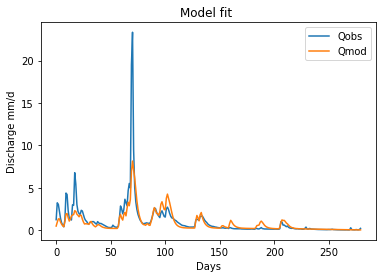

1st Model : OptPar NSE and log NSE for the validation period when modell is run in two phases 0.5972271206549877 0.8813692097970713


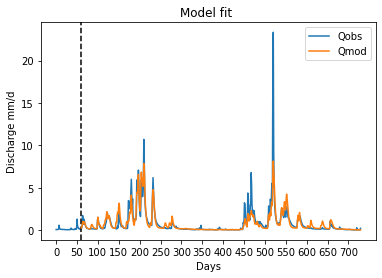

OptPar NSE  0.705 and log NSE  0.900 for full data set  when modell is run in one phase (spin up time)


<Figure size 1440x360 with 0 Axes>

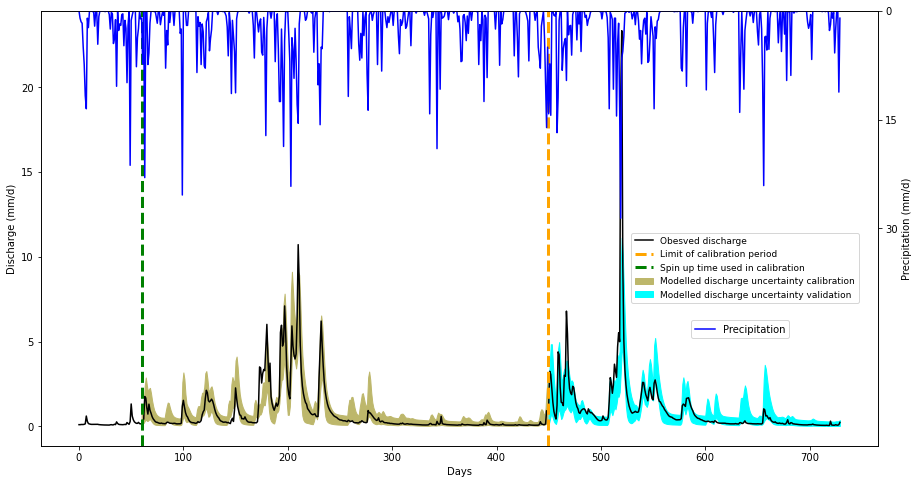

In [4]:
forcing=np.genfromtxt('WarkEttelbruck.txt',dtype=float, autostrip=True)

          #      Imax Ce Sumax beta Pmax   Tlag   Kf  Ks
ParMinn = np.array([0,   0.1,  55,    .5,   .01,   0.1,     .01,  .001])
ParMaxn = np.array([10,    1,  350,   4,    .99,     5,    .9,   .09])
Sin= np.array([0,  100,  0,  5 ])

forcing= forcing[:,1:4]
Q0=forcing[:,0]
prec= forcing[:,1]
tsp=60 # spin up time

forcing_cal= forcing[:450,:] # Around 60 % of the data is chosen for calibration
forcing_val= forcing[450:,:]
# GLUE
nmax=5000
A=np.zeros((nmax,17))
n_feasible = 0
Qm_cal= np.zeros((nmax,len(forcing_cal)-60)) # 60 days is the spin up time used
Qm_val= np.zeros((nmax,len(forcing_val)))

for n in range(1,nmax):
    Rnum= np.random.random_sample(8) #generate a vector of random number
    
    Par= (ParMaxn - ParMinn) * Rnum + ParMinn # calculate the random parameter set
    
    Sin[1]= min(Sin[1],Par[2]) # Initial Su reservoir at the start is not > Sumax
    
    Obj_cal ,LObj_cal,Qmc,Qoc,S_final,WB_cal = HBVMod(Par,forcing_cal,Sin, hydrograph='FALSE',spin_up_time='TRUE')#call the model
    
    Obj_val ,LObj_val,Qmv,Qov,S_final,WB_val = HBVMod(Par,forcing_val,S_final, hydrograph='FALSE',spin_up_time='false')
    
    if (Obj_cal> 0.7) & (LObj_cal> 0.5) and (abs(WB_cal) < 1) :# Insuring around 40 % of models as behavioural
        A[n_feasible,0:8]= Par
        A[n_feasible,8]=Obj_cal
        A[n_feasible,9]=LObj_cal
        A[n_feasible,10]= (1 - Obj_cal)**2 + (1 - LObj_cal)**2
        A[n_feasible,11]=Obj_val
        A[n_feasible,12]=LObj_val
        Qm_cal[n_feasible,:]= Qmc
        Qm_val[n_feasible,:]= Qmv
        n_feasible = n_feasible + 1

A[:,13]= A[:,8]/(np.sum(A[:,8]))# Weighted NSE CALIBRATION
A[:,14]= A[:,9]/(np.sum(A[:,9]))# Weighted log NSE
A[:,15]= A[:,11]/(np.sum(A[:,11]))# Weighted NSE VALIDATION
A[:,16]= A[:,12]/(np.sum(A[:,12]))# Weighted log NSE
Qm_cal=Qm_cal[0:n_feasible,:]
Qm_val=Qm_val[0:n_feasible,:]

np.savetxt('Wark_Table.txt',A[0:n_feasible,:], delimiter =',')
#                      #
#                      #
#                      #  
#                      #
# Calibration table    #
#                      #
#                      #
#                      #
#                      #
Qdt= np.zeros(n_feasible)
Qdt_top_cal= np.zeros(len(Qm_cal[1]))
Qdt_bot_cal= np.zeros(len(Qm_cal[1]))

for i in range(len(Qm_cal[1])):
    Qdt= Qm_cal[:,i]
    Table_cal= np.column_stack((A[:n_feasible,:],Qdt.T))
    Table_caldf=pd.DataFrame(data=Table_cal, index=np.arange(n_feasible))
    Table_caldf.sort_values(by=[17],inplace=True)
    Table_caldf.columns=['Imax','Ce','Sumax','beta','Pmax','Tlag','Kf','Ks','NSE_cal','logN_cal','ED','NSE_val','logN_val','Weighted_NSE','Weighted_log_NSE','Weighted_val_NSE','Weighted_val_log_NSE','Qdt']
    Table_caldf['Cumsum_WNSE']=Table_caldf['Weighted_NSE'].cumsum()
    # Finding upper-lowwer uncertainty boundaries
    Q_top_matrix= Table_caldf['Qdt'][Table_caldf['Cumsum_WNSE'] >= np.percentile(Table_caldf['Cumsum_WNSE'],95)]
    Q_bot_matrix= Table_caldf['Qdt'][Table_caldf['Cumsum_WNSE'] <= np.percentile(Table_caldf['Cumsum_WNSE'],5)]
    Qdt_top_cal[i]= np.min(Q_top_matrix)
    Qdt_bot_cal[i]= np.max(Q_bot_matrix)
#Exporting table
Table_caldf.reset_index(inplace=True)
Table_caldf.to_excel('1st_Model_Table_cal.xlsx')
#                   #
#                   #
#                   #
#                   #
# Validation Table  #
#                   #
#                   #
#                   #
#                   #
Qdt= np.zeros(n_feasible)
Qdt_top_val= np.zeros(len(Qm_val[0,:]))
Qdt_bot_val= np.zeros(len(Qm_val[0,:]))

for j in range(len(Qm_val[0,:])):
    Qdt= Qm_val[:,j]
    Table_val= np.column_stack((A[:n_feasible,:],Qdt.T))
    Table_valdf=pd.DataFrame(data=Table_val, index=np.arange(n_feasible))
    Table_valdf.sort_values(by=[17],ascending=True,inplace=True)
    Table_valdf.columns=['Imax','Ce','Sumax','beta','Pmax','Tlag','Kf','Ks','NSE_cal','logN_cal','ED','NSE_val','logN_val','Weighted_NSE','Weighted_log_NSE','Weighted_val_NSE','Weighted_val_log_NSE','Qdt_val']
    Table_valdf['Cumsum_val_WNSE']=Table_valdf['Weighted_val_NSE'].cumsum()
    # Finding upper-lowwer uncertainty boundaries
    #Q_matrix_val= Table_valdf['Qdt_val','Cumsum_val_WNSE']#[Table_valdf['Cumsum_val_WNSE'] >= np.percentile(Table_valdf['Cumsum_val_WNSE'],90)]
    Q_top_matrix= Table_valdf['Qdt_val'][Table_valdf['Cumsum_val_WNSE'] >= np.percentile(Table_valdf['Cumsum_val_WNSE'],95)]
    Q_bot_matrix= Table_valdf['Qdt_val'][Table_valdf['Cumsum_val_WNSE'] <= np.percentile(Table_valdf['Cumsum_val_WNSE'],5)]
    Qdt_top_val[j]= np.min(Q_top_matrix)
    Qdt_bot_val[j]= np.max(Q_bot_matrix)
#Exporting table
Table_valdf.reset_index(inplace=True)
Table_valdf.to_excel('1st_Model_Table_val.xlsx')

#find the optimum
A= A[A[:,8]>0]
Opt= np.argmax(A[:,8] )
#find the optimal parameter set
OptPar= A[Opt,:8]
np.savetxt('1st_Model_Optimum_Parameter_set.txt',OptPar, delimiter =',')
#
Obj_cal ,LObj_cal,Qmc,Qoc,S_final,WB_cal = HBVMod(OptPar,forcing_cal,Sin, hydrograph='FALSE',spin_up_time='TRUE')

MDL=HBVMod(OptPar,forcing_val,S_final, hydrograph='TRUE',spin_up_time='false')

print('1st Model : OptPar NSE and log NSE for the validation period when modell is run in two phases',MDL[0],MDL[1])
#                                                       #
#                                                       #
# Plotting Uncertainty in Qm with Precipitation and Qobs#
#                                                       #
#                                                       #

Obj= HBVMod(OptPar,forcing,Sin,hydrograph='TRUE',spin_up_time='TRUE')
print(f'OptPar NSE {Obj[0]: .3f} and log NSE {Obj[1]: .3f} for full data set  when modell is run in one phase (spin up time)')
# Final Figure
t_cal= np.arange(tsp,len(Qdt_top_cal)+tsp)
t0_val=len(Qdt_top_cal)+tsp
tmax=len(Q0)
t_val= np.arange(t0_val,tmax)
tobs= np.arange(0,len(Q0))
#
fig = plt.figure(figsize=(20, 5))
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 8)
ax1.plot(Q0, color='black', label='Obesved discharge')
ax2 = ax1.twinx()
ax2 = plt.gca()
ax2.set_ylim(-60,0)
ax2.set_yticks([0,-15,-30])
ax2.set_yticklabels(['0','15','30'])
ax2.set_ylabel('Precipitation (mm/d)')
ax1.set_ylabel('Discharge (mm/d)')
ax1.set_xlabel('Days')
ax2.plot(tobs,-prec, 'b-',label='Precipitation')
ax1.axvline(np.max(t_cal), linewidth=3, linestyle='--', color='orange', label='Limit of calibration period')
ax1.axvline(tsp, linewidth=3, linestyle='--', color='green', label='Spin up time used in calibration')
ax1.fill_between(t_cal,Qdt_bot_cal,Qdt_top_cal,color='darkkhaki', label='Modelled discharge uncertainty calibration')
ax1.fill_between(t_val, Qdt_bot_val, Qdt_top_val, color='cyan', label='Modelled discharge uncertainty validation')
ax1.legend(bbox_to_anchor=(0.7, 0.5), prop={'size': 9})
ax2.legend(bbox_to_anchor=(0.9, 0.3), prop={'size': 10})
#plt.show()
plt.savefig('Model_1_Qobs_Prec_Qm+Uncertainty')

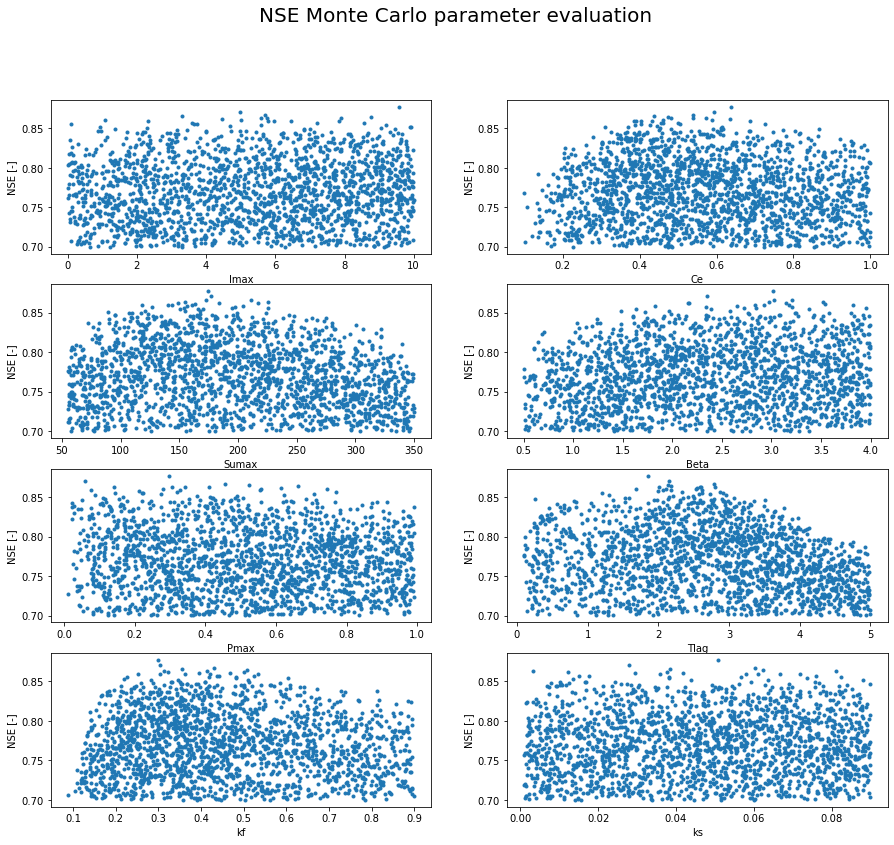

<Figure size 432x288 with 0 Axes>

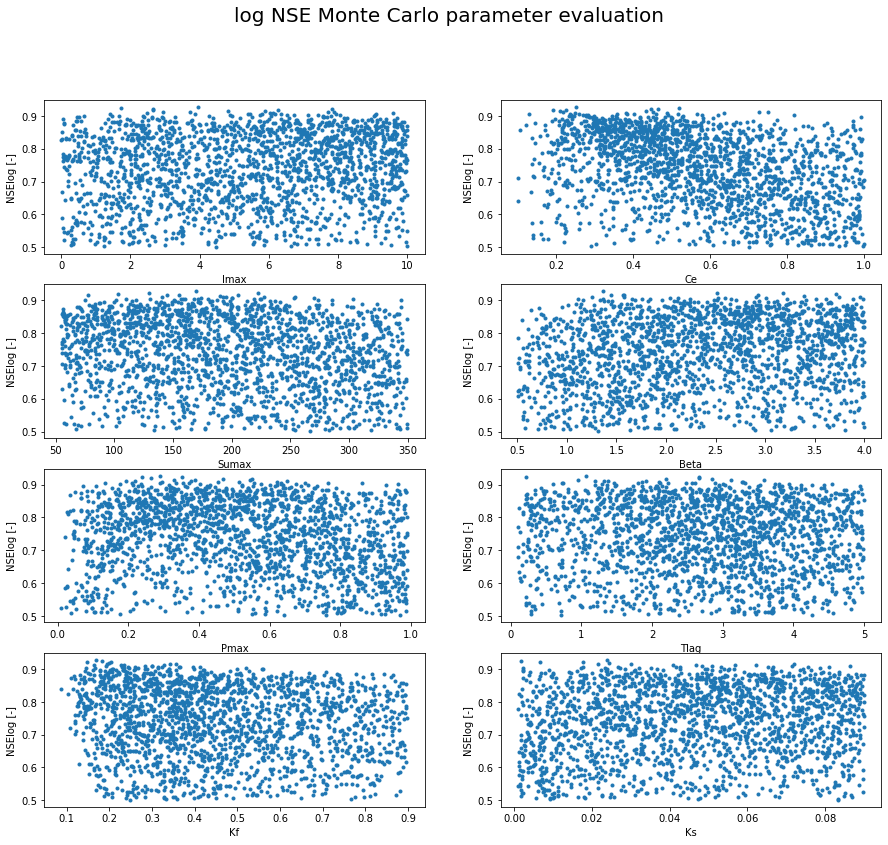

<Figure size 432x288 with 0 Axes>

In [5]:
A=np.genfromtxt('Wark_Table.txt',  dtype=float, autostrip=True, delimiter=',')
A= A[(A[:,8])>0]

#Imax Ce Sumax beta Pmax   Tlag   Kf  Ks

ax1= plt.figure(1,figsize=(15,13))
ax1.suptitle('NSE Monte Carlo parameter evaluation', fontsize=20)
plt.subplot(421)
plt.plot(A[:,0],A[:,8],'.')
plt.xlabel('Imax')
plt.ylabel('NSE [-]')

plt.subplot(422)
plt.plot(A[:,1],A[:,8],'.')
plt.ylabel('NSE [-]')
plt.xlabel('Ce')

plt.subplot(423)
plt.plot(A[:,2],A[:,8],'.')
plt.ylabel('NSE [-]')
plt.xlabel('Sumax')

plt.subplot(424)
plt.plot(A[:,3],A[:,8],'.')
plt.ylabel('NSE [-]')
plt.xlabel('Beta')

plt.subplot(425)
plt.plot(A[:,4],A[:,8],'.')
plt.ylabel('NSE [-]')
plt.xlabel('Pmax')

plt.subplot(426)
plt.plot(A[:,5],A[:,8],'.')
plt.ylabel('NSE [-]')
plt.xlabel('Tlag')

plt.subplot(427)
plt.plot(A[:,6],A[:,8],'.')
plt.ylabel('NSE [-]')
plt.xlabel('kf')

plt.subplot(428)
plt.plot(A[:,7],A[:,8],'.')
plt.ylabel('NSE [-]')
plt.xlabel('ks')
plt.show()
plt.savefig('NSE Monte Carlo evaluation ')
#Imax Ce Sumax beta Pmax   Tlag   Kf  Ks

ax2=plt.figure(2,figsize=(15,13))
ax2.suptitle('log NSE Monte Carlo parameter evaluation',fontsize=20)
plt.subplot(421)
plt.plot(A[:,0],A[:,9],'.')
plt.xlabel('Imax')
plt.ylabel('NSElog [-]')

plt.subplot(422)
plt.plot(A[:,1],A[:,9],'.')
plt.ylabel('NSElog [-]')
plt.xlabel('Ce')

plt.subplot(423)
plt.plot(A[:,2],A[:,9],'.')
plt.ylabel('NSElog [-]')
plt.xlabel('Sumax')

plt.subplot(424)
plt.plot(A[:,3],A[:,9],'.')
plt.ylabel('NSElog [-]')
plt.xlabel('Beta')

plt.subplot(425)
plt.plot(A[:,4],A[:,9],'.')
plt.ylabel('NSElog [-]')
plt.xlabel('Pmax')

plt.subplot(426)
plt.plot(A[:,5],A[:,9],'.')
plt.ylabel('NSElog [-]')
plt.xlabel('Tlag')

plt.subplot(427)
plt.plot(A[:,6],A[:,9],'.')
plt.ylabel('NSElog [-]')
plt.xlabel('Kf')

plt.subplot(428)
plt.plot(A[:,7],A[:,9],'.')
plt.ylabel('NSElog [-]')
plt.xlabel('Ks')
plt.show()
plt.savefig('log NSE Monte Carlo evaluation ')

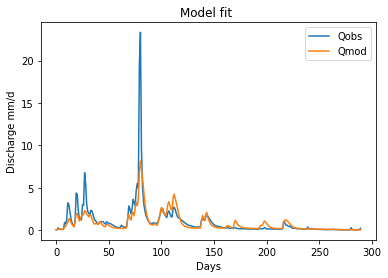

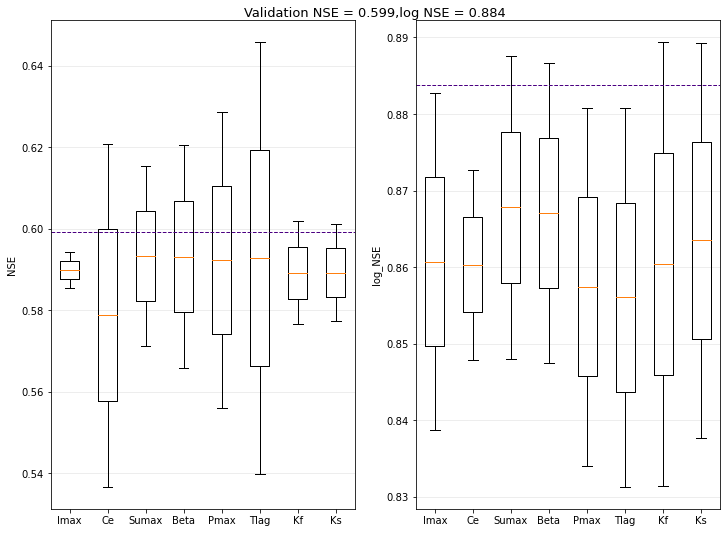

In [7]:
OptPar=np.genfromtxt('1st_Model_Optimum_Parameter_set.txt',  dtype=float, autostrip=True)
forcing=np.genfromtxt('WarkEttelbruck.txt',  dtype=float, autostrip=True)
          #      Imax Ce Sumax beta Pmax   Tlag   Kf  Ks
ParMinn = np.array([0,   0.1,  55,    .5,   .01,   0.1,     .01,  .0001])
ParMaxn = np.array([10,    1,  550,   4,    .99,     5,    .9,   .09])
Sin= np.array([0,  100,  0,  5  ])

forcing= forcing[:,1:4]
forcing_cal=forcing[:440,:]
forcing_val= forcing[440:,:]
Obj_cal= HBVMod(OptPar,forcing_cal,Sin,hydrograph='FALSE',spin_up_time='TRUE')
Obj= HBVMod(OptPar,forcing_val,Obj_cal[4],hydrograph='TRUE',spin_up_time='FALSE')
NSE=np.zeros((3,8))
log_NSE=np.zeros((3,8))
Par_t= np.zeros((3, 8))
#
for i in range (3):
    for j in range(8):
        ParC=OptPar
        if i==0:
            ParC[j]=OptPar[j]
        elif i==1:
            ParC[j]= ParC[j] * 1.2
        else:
            ParC[j]= ParC[j] * 0.8
        obj_cal= HBVMod(OptPar,forcing_cal,Sin,hydrograph='FALSE',spin_up_time='TRUE')
        NSE[i,j], log_NSE[i,j] = HBVMod(ParC,forcing_val,obj_cal[4],hydrograph='False',spin_up_time='FALSE')[0:2]
        Par_t[i,j]= ParC[j]
fig1 = plt.figure(figsize = (12,9))
plt.suptitle('Validation NSE = '+str(np.round(Obj[0],3))+',log NSE = '+str(np.round(Obj[1],3)),y=0.9,fontsize=13)
ax1 = fig1.add_subplot(121)
ax1.boxplot(x=NSE[1:,0:8], labels = ['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks'], sym = '')
ax1.set_ylabel('NSE')
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
ax1.axhline(float(Obj[0]), linewidth=1, linestyle='--', color='indigo', label='Optimum parameter NSE')
#ax1.set_title('Parameter +/- 20% impact on NSE')
ax2 = fig1.add_subplot(122)
ax2.boxplot(x=log_NSE[1:,0:8], labels = ['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks'], sym = '')
ax2.set_ylabel('log_NSE')
ax2.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
ax2.axhline(float(Obj[1]), linewidth=1, linestyle='--', color='indigo', label='Optimum parameter log NSE')
plt.savefig('Sensitivity_change_20%_box_plot')